# Energy Point Selection

This notebook demonstrates how to select energy points that help the most to identify linear combinations of Reference spectra.

In [1]:
import selector
from selector import energy_point_selector
import itertools

import mlmodels

import utils
from importlib import reload

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import *
from sklearn.feature_selection import chi2

from scipy.interpolate import interp1d
from scipy.optimize import basinhopping

utils = reload(utils)
from utils import *

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

# Load Reference Data
Read in example XANES spectra in `Data` folder.

In [3]:
exp = parse_file('Reference Data/As_exp_standards_normalized.dat')
sim = parse_file('Reference Data/As_edge_sim_standards_phases_normalized.dat')
defect = parse_file('Reference Data/As_defects_normalized.dat')

In [4]:
energy = np.array(sim['X1'], dtype=float)

sim_data_columns = [colm for colm in sim.columns if len(colm.replace('X', '')) > 3]
Sim_Refs = np.array(sim[sim_data_columns], dtype=float).T

exp_data_columns = [colm for colm in exp.columns if len(colm.replace('X', '')) > 3]
Exp_Refs = np.array(exp[exp_data_columns], dtype=float).T

defect_data_columns = [colm for colm in defect.columns if len(colm.replace('X', '')) > 3]
Defect_Refs = np.array(defect[defect_data_columns], dtype=float).T

In [5]:
refs = np.concatenate((Sim_Refs, Exp_Refs, Defect_Refs), axis=0)

Energy = np.linspace(min(energy), max(energy), 145)
m = np.argmin((Energy - (11915))**2)
interperlator = interp1d(energy, refs)
Energy = Energy[:m]
Refs = interperlator(Energy)
print(f"Resolution: {Energy[1] - Energy[0]}")
print(Energy.shape, Refs.shape)

data_columns = sim_data_columns + exp_data_columns + defect_data_columns

Resolution: 0.4958888888886577
(118,) (33, 118)


In [6]:
whiteline = Energy[np.argmax(Refs[24])]  # As2O3 Ref
print(data_columns[24])
print(f"whiteline: {whiteline} eV")

exp As2O3 0112 (ASU standard)
whiteline: 11871.988555555556 eV


In [7]:
choice_indices = np.sort([27, 4, 11, 22, 28, 30, 31, 23, 9, 16, 8, 19])
data_columns = [data_columns[i] for i in choice_indices]
Refs = np.array([Refs[i] for i in choice_indices])

## Visualize reference spectra

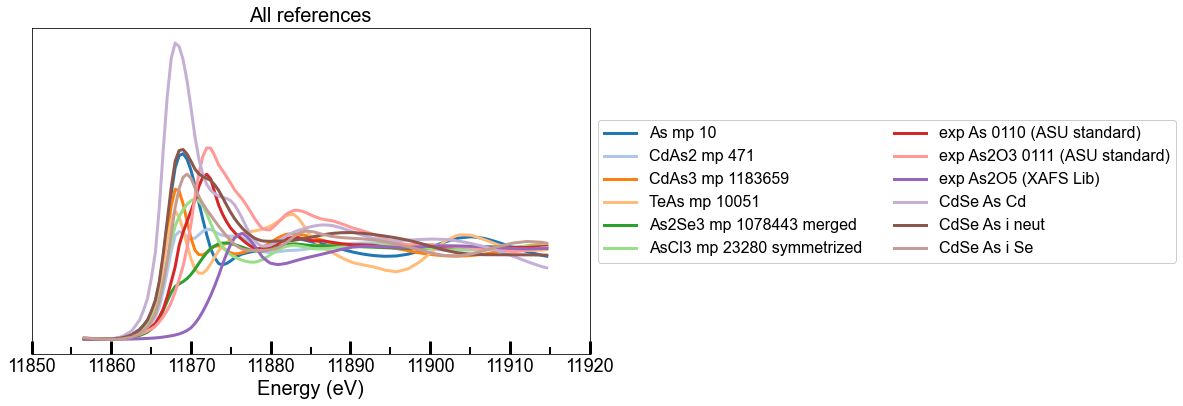

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, ref in enumerate(Refs):
    if i >= 20:
        c = i - 20
    else:
        c = i
    label = f'{data_columns[i]}'#\nE = {Energy[np.argmax(ref)]}'
    ax.plot(Energy, ref, '-', linewidth=3, c=plt.cm.tab20(c/19), label=label, alpha=1.)
ax.legend(fontsize=16, loc='center left', bbox_to_anchor=(1., .5), ncol=2, framealpha=1.)
plt.title("All references", fontsize=20)
format_axis(ax, ticks=(5,10))
plt.show()

# PCA Analysis

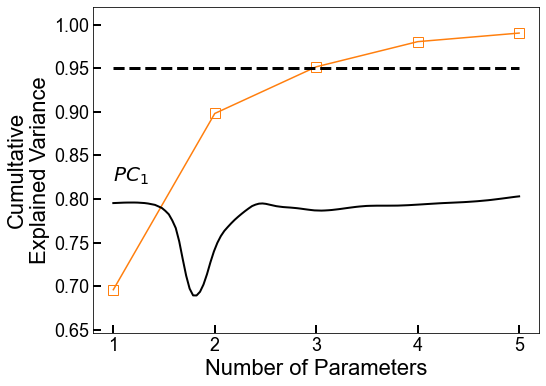

In [9]:
make_scree_plot(Refs) 
plt.savefig('Figures/scree.png', dpi=800, bbox_inches='tight', transparent=True)

# Generate dataset using linear combinations of reference spectra

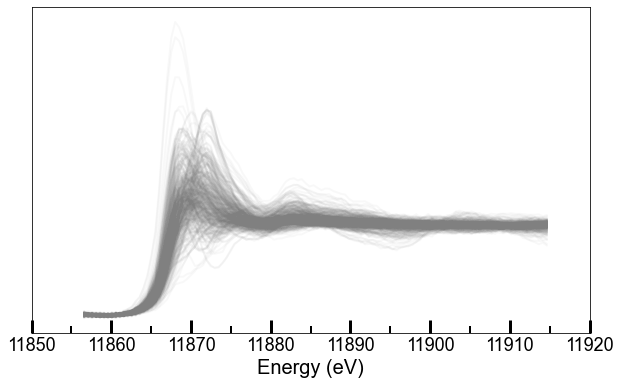

In [22]:
kwargs = {'N': 500, 'scale': 0.01, 'dropout': 0.9, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 50, 'scale': 0.01, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)

plot_spectra(Energy, data, mod=0, alpha=0.05)

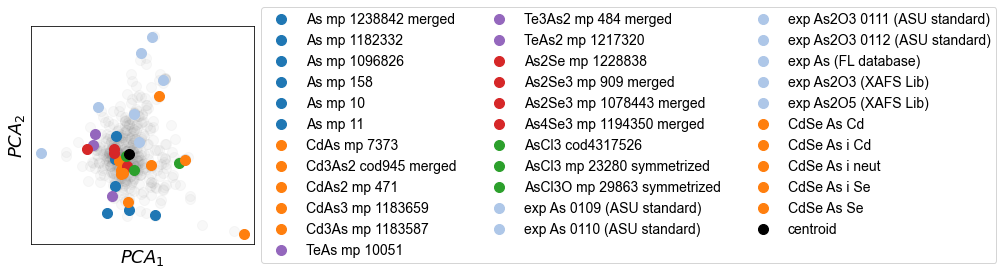

In [23]:
two_dimensional_visualization(data, Refs, data_columns, ncol=3, method='PCA', fontsize=18)

# $\chi^2$ Fit

In [10]:
kwargs = {'N': 10000, 'scale': 0.0, 'dropout': 0.9, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)

In [11]:
Pvals = []
Chi2 = []
for i in range(coeffs.shape[1]):
    labels = coeffs[:, i] > 0
    chi2_vals, p_vals = chi2(data, labels)
    Pvals.append(p_vals)
    Chi2.append(chi2_vals)

In [12]:
np.array(Chi2).shape

(12, 118)

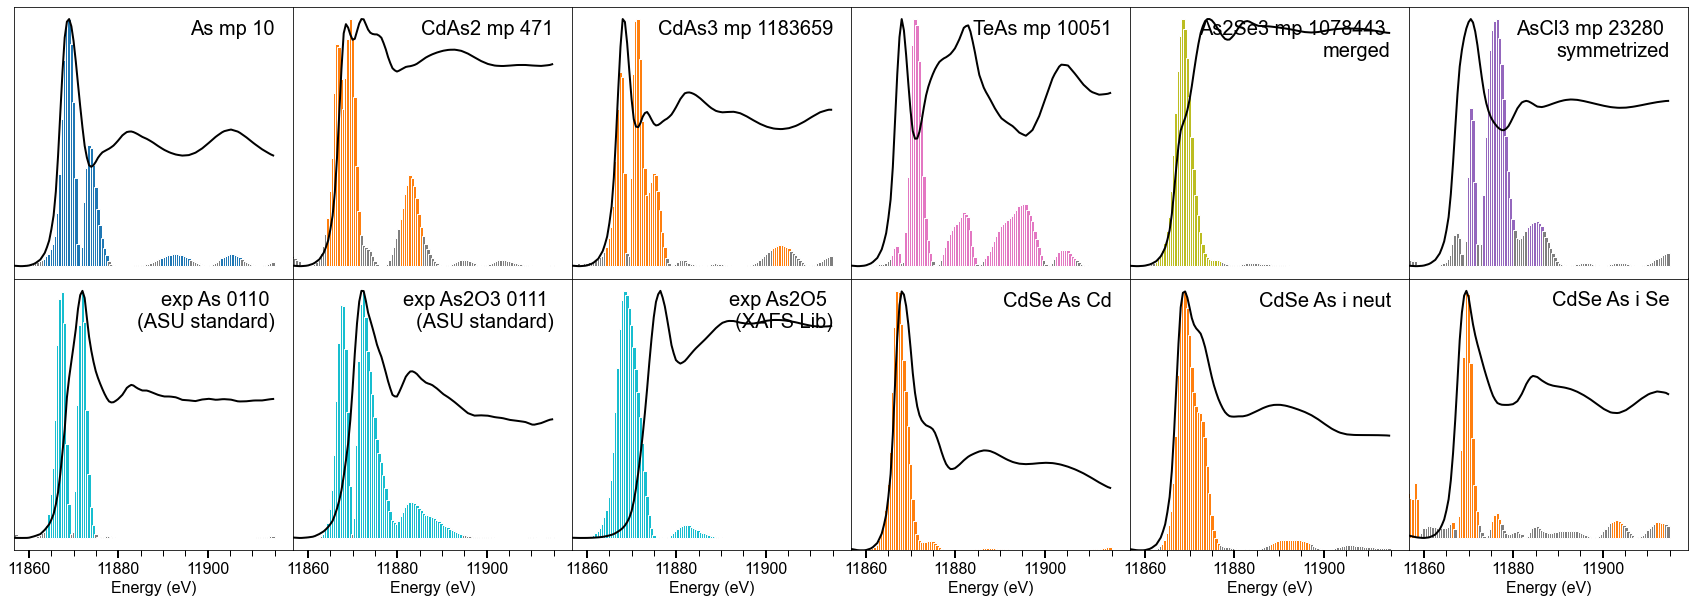

In [14]:
N = np.array(Chi2).shape[0]
ncols = 6
nrows = N//ncols
if nrows * ncols < N:
    nrows += 1

Chi2 = np.array(Chi2)
Pval = np.array(Pvals)
fig, axes = plt.subplots(figsize=(5 * ncols, 5 * nrows), ncols=ncols, nrows=nrows)
plt.subplots_adjust(wspace=0, hspace=0)

ele_to_color_map = {'Cd': 1, 'Te': 6, 'Se': 8, 'Cl': 4, 'exp': 9, 'As': 0}

max_chi2_val = np.max(Chi2)
alpha = 0.05

for i, j in itertools.product(range(nrows), range(ncols)):
    k = (i * ncols) + j
    ax = axes[i, j]
    if k + 1 <= N:
        normalized_chi2 = Chi2[k] / np.max(Chi2[k])

        label = data_columns[k]
        if '(' in label:
            label = label.replace('(', '\n(')
        if 'merged' in label:
            label = label.replace('merged', '\nmerged')
        if 'symmetrized' in label:
            label = label.replace('symmetrized', '\nsymmetrized')
        
        for key in ele_to_color_map.keys():
            if key in label:
                c = ele_to_color_map[key]
                break
            
        reject_bool_arr = Pval[k] < alpha
        reject_indices = np.arange(len(Pval[k]))[reject_bool_arr]
        colors = np.array([plt.cm.tab10(7) for k in range(len(Energy))])
        colors[reject_indices, :] = plt.cm.tab10(c)
        
        ax.bar(Energy, normalized_chi2, color=colors, edgecolor='w')
        ax.text(11915, 1, label, ha="right", va="top", size=20)
        ax.set_yticks([])
        
        if i == nrows - 1:
            ax.xaxis.set_major_locator(MultipleLocator(20))
            ax.xaxis.set_minor_locator(MultipleLocator(5))
            ax.tick_params(direction='out', width=2, length=8, which='major', axis='x')
            ax.tick_params(direction='out', width=1, length=6, which='minor', axis='x')
            ax.set_xticks(np.array(ax.get_xticks(), dtype=int))
            ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int), fontsize=16)
            ax.set_xlabel("Energy (eV)", fontsize=16)
        else:
            ax.set_xticks([])
        
        ref = Refs[k]
        ax.plot(Energy, ref / np.max(ref), 'k-', linewidth=2)
        
        ax.set_xlim(min(Energy), 11919)
    else:
        ax.axis('off')
        
plt.savefig('Figures/chi2_with_defects.png', dpi=800, transparent=True, bbox_inches='tight')

# Enumeration of points 9 and 10

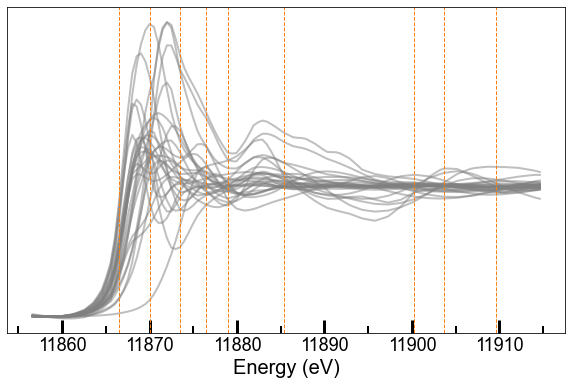

In [11]:
indices = [27, 40, 20, 95, 88, 34, 45, 58, 107]
energy_measurements = [Energy[i] for i in indices]

fig, ax = plt.subplots(figsize=(10, 6))
m = np.argmin((Energy - 11915)**2)
for i, ref in enumerate(Refs):
    ax.plot(Energy, ref, '-', linewidth=2, c='gray', alpha=0.5)
format_axis(ax)

for energy in energy_measurements:
    ax.axvline(energy, c=plt.cm.tab20(2), linestyle='--', linewidth=1.)

plt.show()

In [24]:
kwargs = {'N': 100, 'scale': 0.0, 'dropout': 0.9, 'training': False}
train_data, train_coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 5, 'scale': 0.0, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)

In [25]:
Refs.shape, data.shape, coeffs.shape

((28, 118), (500, 118), (500, 28))

In [26]:
cropped_indices = [27, 40, 20, 95, 88, 34, 45, 58]

Epairs = []
Scores = []
metric = 'mean_absolute_error'
mode = 'ML'

for k, ei in enumerate(Energy):
    for l, ej, in enumerate(Energy):
        if k < l:
            print(f"{k}, {l}", end='\r')
            #temp_indices = []
            temp_indices = cropped_indices.copy()
            for idx in [k, l]:
                temp_indices.append(idx)
            temp_indices = np.sort(temp_indices)

            # get MAE                
            if mode == 'min':
                temp_metric = []
                sub_spectra = data[:, temp_indices]
                pred_coeffs = get_coeffs_from_sepctra(sub_spectra, Refs[:, temp_indices])
                for k, pred_coeff in enumerate(pred_coeffs):
                    metric = mae_loss(pred_coeff, Refs, data[k])
                    temp_metric.append(metric)
                score = np.average(temp_metric)
            elif mode == 'ML':
                score = train_RF(Refs, temp_indices, train_data, train_coeffs, test_data, test_coeffs,
                                 metric=metric)

            Epairs.append([ei, ej])
            Scores.append(score)
    print('        ', end='\r')

Scores = np.array(Scores)
Epairs = np.array(Epairs)
Epairs.shape

(6903, 2)

In [65]:
size_Z = Refs.shape[1] - 1
Z = np.zeros((size_Z, size_Z))
Z[np.triu_indices(Z.shape[0], k = 0)] = Scores
Z = Z + Z.T - np.diag(np.diag(Z))
x = np.unique(Epairs)[:-1]
X, Y = np.meshgrid(x, x)

ValueError: shape mismatch: value array of shape (6903,)  could not be broadcast to indexing result of shape (134940,)

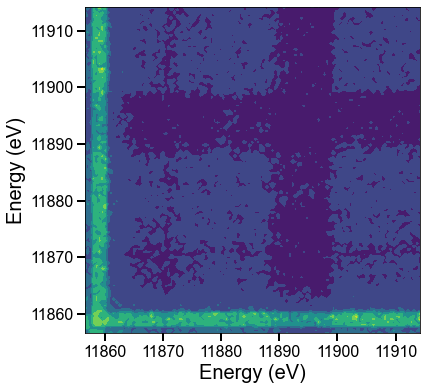

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.contourf(X, Y, Z)

ax.tick_params(direction='out', width=2, length=8, which='major', axis='both')
ax.set_yticklabels(np.array(Energy, dtype=float), fontsize=16)
ax.set_xticklabels(np.array(Energy, dtype=float), fontsize=16)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_ylabel("Energy (eV)", fontsize=20)
ax.set_xlabel("Energy (eV)", fontsize=20)
plt.savefig('Figures/enumeration_contour_9_and_10.png', dpi=800, transparent=True)

# Simulated Annealing Monte Carlo (SAMC)

In [104]:
Energy = np.linspace(11858, 11910, 521)
m = np.argmin((Energy - (11915))**2)
interperlator = interp1d(energy, refs)
Energy = Energy[:m]
Refs = interperlator(Energy)
print(f"Resolution: {Energy[1] - Energy[0]}")
print(Energy.shape, Refs.shape)

Resolution: 0.1000000000003638
(520,) (28, 520)


In [105]:
kwargs = {'N': 500, 'scale': 0.0, 'dropout': 0.9, 'training': False}
train_data, train_coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 50, 'scale': 0.0, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)

In [109]:
def reconstruction_loss(energies, Energy, Refs, data, metric):
    train_data, train_coeffs, test_data, test_coeffs = data
    energy_indices = np.array([np.argmin((Energy - e)**2) for e in energies])
    error = train_RF(Refs, energy_indices,
                     train_data, train_coeffs, test_data, test_coeffs,
                     metric=metric, spectra=False)
    return -error

In [110]:
data = (train_data, train_coeffs, test_data, test_coeffs)
args = (Energy, Refs, data, 'mean_absolute_error')
x0 = np.array([11870.  , 11876.45, 11866.53, 11903.73, 11900.25,
               11873.48, 11878.93, 11885.38, 11909.68])
result = basinhopping(reconstruction_loss, x0, niter=500, stepsize=0.1,
                      minimizer_kwargs={'method': 'BFGS', 'args': args})

In [111]:
print(result)

                        fun: -0.0360092213891043
 lowest_optimization_result:       fun: -0.0360092213891043
 hess_inv: array([[ 1.1603109 ,  0.00301552,  0.1328053 ,  0.3658759 , -0.12270613,
         0.50119411, -0.08866242, -0.17268613,  0.08494606],
       [ 0.00301552,  0.74016424, -0.0825972 ,  0.10991194, -0.29157983,
         0.12928405, -0.19293489, -0.28869974, -0.08889203],
       [ 0.1328053 , -0.0825972 ,  1.08215667,  0.33683465, -0.19636744,
         0.45444491, -0.13607568, -0.2365212 ,  0.04074264],
       [ 0.3658759 ,  0.10991194,  0.33683465,  1.7941905 , -0.16537443,
         1.0963552 , -0.12652895, -0.28095771,  0.22974458],
       [-0.12270613, -0.29157983, -0.19636744, -0.16537443,  0.77195047,
        -0.25022163, -0.14502412, -0.18554145, -0.16573913],
       [ 0.50119411,  0.12928405,  0.45444491,  1.0963552 , -0.25022163,
         2.51165237, -0.1889852 , -0.4082403 ,  0.30730619],
       [-0.08866242, -0.19293489, -0.13607568, -0.12652895, -0.14502412,
   

In [112]:
x = result['x']
x = np.sort(x)
print(x)
x_indices = np.array([np.argmin(abs(Energy - e)) for e in x])

[11867.54597544 11869.9417411  11871.49389955 11877.15085903
 11881.09436953 11884.28701515 11894.52969538 11901.02636848
 11907.74710915]


In [113]:
x0_indices = np.array([np.argmin(abs(Energy - e)) for e in x0])

In [114]:
print(Energy[x_indices] - x)
print(Energy[x0_indices] - x0)

[-0.04597544 -0.0417411   0.00610045  0.04914097  0.00563047  0.01298485
 -0.02969538 -0.02636848 -0.04710915]
[ 0.    0.05 -0.03 -0.03 -0.05  0.02 -0.03  0.02  0.02]


In [115]:
print(x0_indices - x_indices)
print(x0 - x)

[  25   66  -50  265  191 -108 -156 -156   20]
[  2.45402456   6.5082589   -4.96389955  26.57914097  19.15563047
 -10.80701515 -15.59969538 -15.64636848   1.93289085]


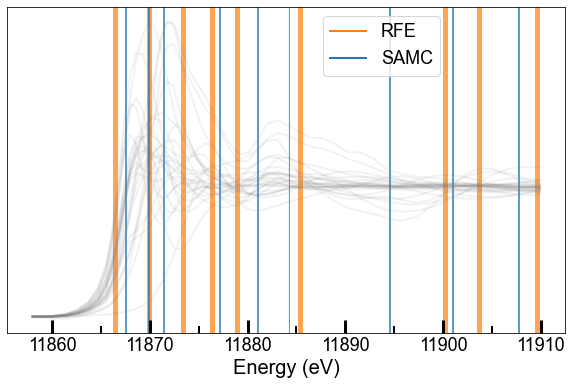

In [118]:
fig, ax = plt.subplots(figsize=(10, 6))
m = np.argmin((Energy - 11915)**2)
for i, ref in enumerate(Refs):
    ax.plot(Energy, ref, '-', linewidth=2, c='gray', alpha=0.1)
format_axis(ax)

for i in range(len(x0)):
    e, e0 = x[i], x0[i]
    if i == 0:
        labels = ['RFE', 'SAMC']
    else:
        labels = [None, None]
    ax.axvline(e0, c=plt.cm.tab20(2), linestyle='-', linewidth=.1, label=labels[0])
    ax.axvline(e, c=plt.cm.tab20(0), linestyle='-', linewidth=.1, label=labels[1])    
    
    ax.axvspan(e0 - 0.25, e0 + 0.25, fc=plt.cm.tab20(2), alpha=0.7)
    ax.axvspan(e - 0.1, e + 0.1, fc=plt.cm.tab20(0), alpha=0.7)

leg = plt.legend(fontsize=18, loc='upper left', bbox_to_anchor=(.55, 1.))
for l in leg.get_lines():
    l.set_linewidth(2)
plt.savefig('Figures/RFE_vs_SAMC_spaghetti_more_iters.png', dpi=800, transparent=True)

# Augment dataset using a GAN

In [48]:
mlmodels = reload(mlmodels)

In [49]:
latent_dim = 15
# wgan = mlmodels.WGAN(Refs, latent_dim)
args = [Refs, latent_dim]
wgan = mlmodels.WGAN_GP(0.1, *args)

kwargs = {'N': 5, 'scale': 0.0, 'dropout': 0.1 , 'training': False}
real_data, real_coeffs = generate_linear_combos(Refs, **kwargs)
fake_data, fake_coeffs = wgan.generate_fake_samples(6, training=False)

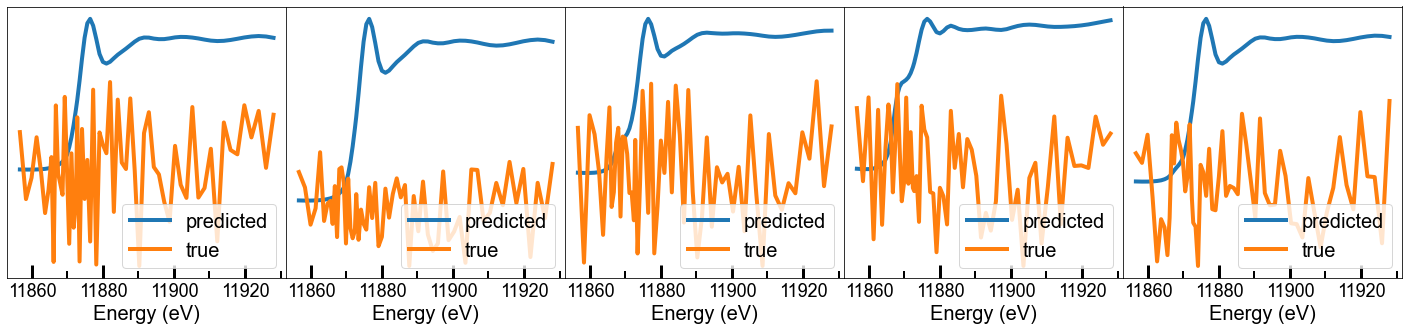

mean absolute error: 0.7634401166242417


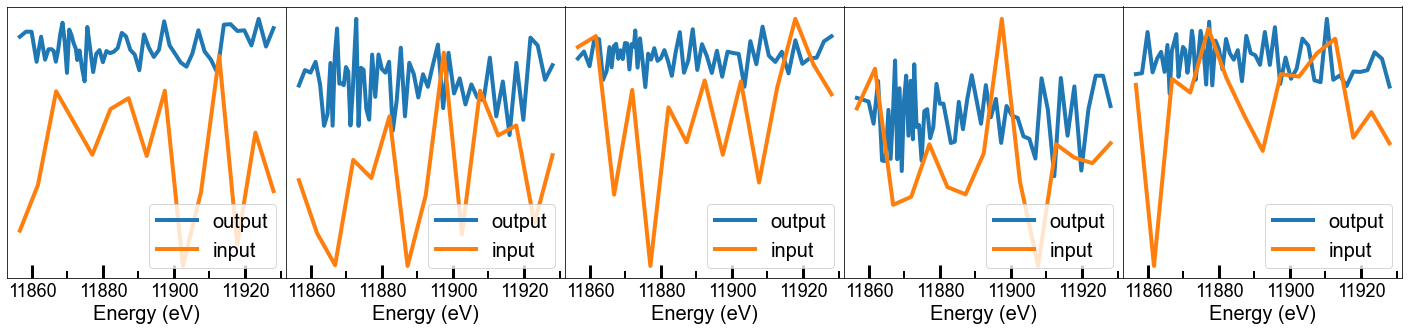

In [50]:
plot_reconstructions(fake_data, fake_coeffs, 5, Energy, Refs)
wgan.plot_input_output(5, Energy, Refs)

Discriminator Loss is the main convergence metric for GANs. Discriminator loss is the (negative) approximation of the Wasserstein distance so it should converge to zero (can't tell the different between real and fake images).

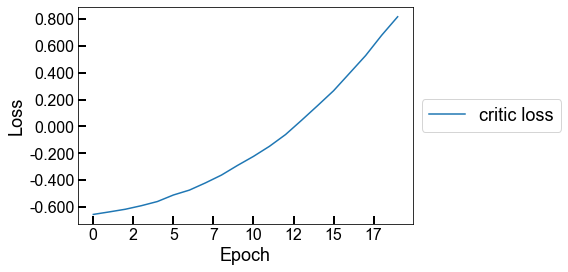

In [51]:
wgan.train(n_epochs=20, n_batch=128)

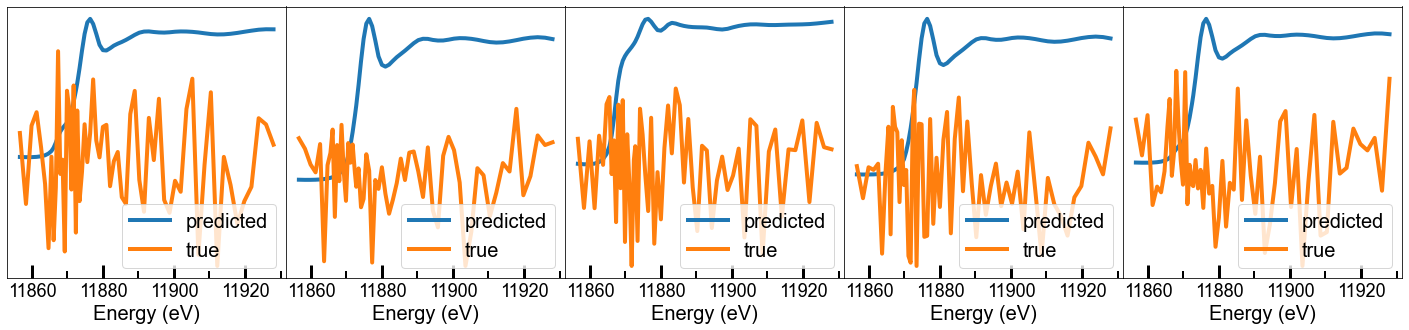

mean absolute error: 0.8227665471810036


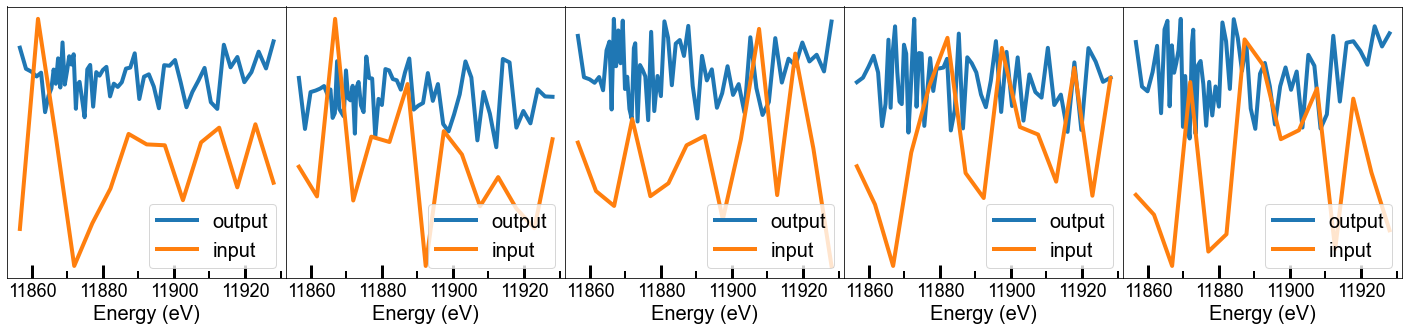

In [52]:
fake_data, fake_coeffs = wgan.generate_fake_samples(5, training=False)
noise = wgan._generate_latent_points(5)
plot_reconstructions(fake_data, fake_coeffs, 5, Energy, Refs)
wgan.plot_input_output(5, Energy, Refs)

# Initialize Selector and perform selection algorithm

### Some potential advancements:

1. Logistic regression and xgboost are models with feature importances that will work if the labels were one dimensional. A work around is using a RegressorChain or MultiOutputRegressor wrapper model.

2. Gaussian processes and other nonlinear models would work if permutation_importance worked as the importance_getter

e.g.

` def importance(model):`
    
 &emsp; &emsp; ` return permutation_importance(model, data, coeffs, scoring='neg_mean_squared_error')`
    
` importance_getter = importance`

These features can theoretically be implemented to improve the RFE algorithm.

In [104]:
energy_point_selector = reload(selector.energy_point_selector)
select = energy_point_selector.Selector(data, coeffs)

For a list of possible scoring criteria, see `sklearn.metrics.SCORERS.keys()`

In [13]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
n_points = [18]
Scores = []
Epts = []

for npts in n_points:
    print(f'\nNum points: {npts}\n-----------------------')
    scores = []
    epts = []
    for model in models:
        print(f'\n{model}:')
        select = energy_point_selector.Selector(data, coeffs)
        rfe, cvscore = select.select_energy_points(estimator=model, n_points=npts,
                                                   scoring='neg_root_mean_squared_error')
        energy_points = Energy[rfe.support_]
        epts.append(energy_points)
        scores.append(cvscore)
    Scores.append(scores)
    Epts.append(epts)

# Visualize Selected Energy Points

In [ ]:
nrows = len(n_points)
ncols = len(models)
fig, axes = plt.subplots(figsize=(ncols*5, nrows*5), nrows=nrows, ncols=ncols)
plt.subplots_adjust(wspace=0, hspace=0.45)

for i, npts in enumerate(n_points):
    row_axes = axes[i]
    for energy_pts, model, score, ax in zip(Epts[i], models, Scores[i], row_axes):
        diff = 25
        ticks = (10, 20)
        visualize_energy_points((fig, ax), Energy, Refs,
                                energy_pts, ticks=ticks, label=model)
        text = ax.text(np.max(Energy) - diff, np.max(Refs)*0.5, f'RMSE:\n{-score:.3}',
                       ha="left", va="center", size=20)
    label = row_axes[0].set_ylabel(f'n = {npts}', fontsize=20)

# Model Selection

Variation for different datasets made with the same References.

In [105]:
energy_point_selector = reload(selector.energy_point_selector)

In [ ]:
best_estimator = 'Random Forest'
best_n = 12
Is = []

reps = 30
for i in range(reps):
    print(i, end='\r')
    kwargs = {'N': 1000, 'scale': 0.01, 'dropout': 0.9, 'training': False}
    data, coeffs = generate_linear_combos(Refs, **kwargs)
    
    select = energy_point_selector.Selector(data, coeffs)
    rfe = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                      verbose=False, scoring='neg_root_mean_squared_error',
                                      n_estimators=30)
    energy_measurements = Energy[rfe.support_]
    indices = [i for i, e in enumerate(Energy) if e in energy_measurements]
    Is.append(indices)
Is = np.array(Is)

[Text(0, 0, '-10'),
 Text(0, 0, '0'),
 Text(0, 0, '10'),
 Text(0, 0, '20'),
 Text(0, 0, '30'),
 Text(0, 0, '40'),
 Text(0, 0, '50'),
 Text(0, 0, '60'),
 Text(0, 0, '70'),
 Text(0, 0, '80'),
 Text(0, 0, '90'),
 Text(0, 0, '100'),
 Text(0, 0, '110'),
 Text(0, 0, '120'),
 Text(0, 0, '130'),
 Text(0, 0, '140'),
 Text(0, 0, '150')]

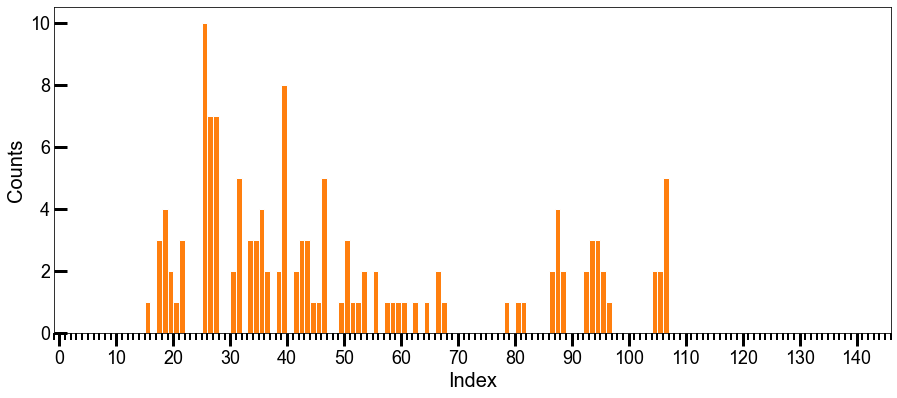

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
indices = [27, 40, 144, 20, 95, 88, 34, 45, 58, 107]
labels = np.arange(1, len(indices) + 1)
label_map = {idx: label for idx, label in zip(indices, labels)}
histogram((fig, ax), Is.reshape(-1), bins=Refs.shape[1] + 1, ticks=(1, 10),
           label_map=None)
ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int), fontsize=18)
#plt.savefig('Figures/histogram_of_importances_noise_1_percent_0.5_eV_intervals.png',
#            dpi=800, transparent=True)

`best_estimator = 'Random Forest'`

`best_n = 12`

`dropout': 0.9`

### Noise = 5%

`n_estimators=30`

`indices = [14, 10, 15, 13, 24, 30, 20, 18, 21, 40]`

### Noise = 3%:

`n_estimators=30`                                                                            

`indices = [15, 13, 22, 9, 24, 31, 41, 18, 20, 27]`

### Noise = 1%:

`n_estimators = 2`

`indices = [14, 24, 46, 21, 9, 18, 30, 33, 44, 50, 54, 27, 35, 42]`

`n_estimators = 50`

`indices = [14, 46, 24, 9, 50, 44, 21, 27, 30, 33, 54, 18, 35, 42]`

#### Interpolated to 200 energy points:

`n_estimators = 30`

`cutoff = + 45 eV`

`indices = [47, 122, 36, 40, 62, 29, 53, 93, 46, 55]`

#### Interpolated to 145 energy points:

`n_estimators = 30`

`cutoff = + 45 eV`

`indices = [27, 40, 144, 20, 95, 88, 34, 45, 58, 107]`

## Validating energy points

In [14]:
kwargs = {'N': 1000, 'scale': 0.01, 'dropout': 0.9, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 500, 'scale': 0.01, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)

In [15]:
best_estimator = 'Linear Regression'
best_n = 12

select = energy_point_selector.Selector(data, coeffs)
rfe, cvscore = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                           scoring='neg_root_mean_squared_error')
energy_measurements = Energy[rfe.support_]
indices = [i for i, e in enumerate(Energy) if e in energy_measurements]

Score: -0.018 (0.000)


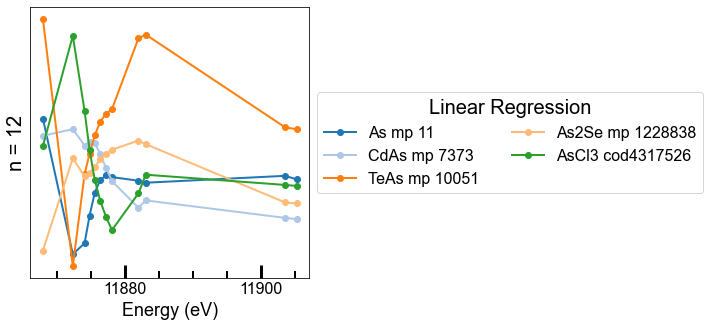

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))

diff = 11.8
diff = -2
ticks = (5, 20)
fontsize = 20

n = Refs.shape[0]
ele_to_idx_map = {'Cd': 2, 'Te': 8, 'Se': 6, 'Cl': 4, 'exp': 1, 'As': 0}
for i, ref in enumerate(Refs[:, indices]):
    label = data_columns[i]
    for key in ele_to_idx_map.keys():
        if key in label:
            j = ele_to_idx_map[key]
            break
    if n < 20:
        c = i
    else:
        c = j
    color = plt.cm.tab20(c)  
    ax.plot(Energy[indices], ref, 'o-', linewidth=2, c=color, label=label)

    format_axis(ax, ticks=ticks, fontsize=fontsize-2)
ax.legend(fontsize=fontsize-4, loc='center left', bbox_to_anchor=(1., .5),
         title=f'{best_estimator}', title_fontsize=fontsize, ncol=2)
label = ax.set_ylabel(f'n = {best_n}', fontsize=20)

In [44]:
indices = [27, 40, 20, 95, 88, 34, 45, 58, 107]
energy_measurements = [Energy[i] for i in indices]

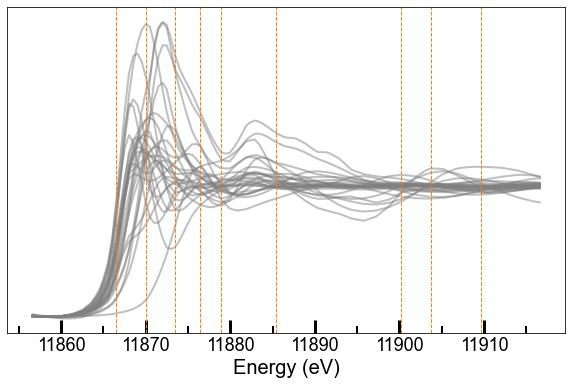

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
m = np.argmin((Energy - 11915)**2)
for i, ref in enumerate(Refs):
    ax.plot(Energy, ref, '-', linewidth=2, c='gray', alpha=0.5)
format_axis(ax)

for energy in energy_measurements:
    ax.axvline(energy, c=plt.cm.tab20(2), linestyle='--', linewidth=1.)

plt.show()

## Validate Regression Task using energy subset

Train and score each regression model using the selected energy subset to predict the linear combination coefficients.

In [315]:
ref_coeff = np.identity(Refs.shape[0])
m, x, y, z = 'Model', 'Train', 'Validation', 'Refs'
print(f'{m:45s}| {x:20s}| {y:20s}| {z:20s} ')
print('-'*105)
    
for reg in [LinearRegression(), RandomForestRegressor(), DecisionTreeRegressor(),
            GaussianProcessRegressor(), MLPRegressor(hidden_layer_sizes=(40, 40)),
            Lasso()]:
    
    reg.fit(data[:, indices], coeffs)
    
    x = f'{reg.score(data[:, indices], coeffs):.4f}'
    y = f'{reg.score(test_data[:, indices], test_coeffs):.4f}'
    z = f'{reg.score(Refs[:, indices], ref_coeff):.4f}'
    print(f'{str(reg):45s}| {x:20s}| {y:20s}| {z:20s} ')

Model                                        | Train               | Validation          | Refs                 
---------------------------------------------------------------------------------------------------------
LinearRegression()                           | 0.3428              | -0.1874             | 0.3654               
RandomForestRegressor()                      | 0.9711              | 0.6737              | 1.0000               
DecisionTreeRegressor()                      | 1.0000              | 0.0834              | 1.0000               
GaussianProcessRegressor()                   | 0.9003              | 0.6286              | 0.9963               
MLPRegressor(hidden_layer_sizes=(40, 40))    | 0.2977              | -0.0544             | 0.3356               
Lasso()                                      | 0.0000              | -0.1274             | -0.0001              


` The Random Forest Regressor performed the best and subsequent analysis should use this model.`

## Test dataset
Test on experimental data.

In [25]:
kwargs = {'N': 10000, 'scale': 0.01, 'dropout': 0.9, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 100, 'scale': 0.01, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)

In [26]:
reg = LinearRegression()
sorted_indices = np.sort([27, 40, 144, 20, 95, 88, 34, 45, 58, 107])
reg.fit(data[:, sorted_indices], coeffs)

y_pred = reg.predict(test_data[:, sorted_indices])
print(f'Add to one? {np.sum(y_pred, axis=1).all()}')

for metric in ["mean_squared_error", "explained_variance_score"]:
    test_score = eval(metric)(y_pred, test_coeffs)
    metric = metric.replace('_', ' ')
    print(f'{metric}: {test_score:.5f}')

Add to one? True
mean squared error: 0.01029
explained variance score: -1.86196


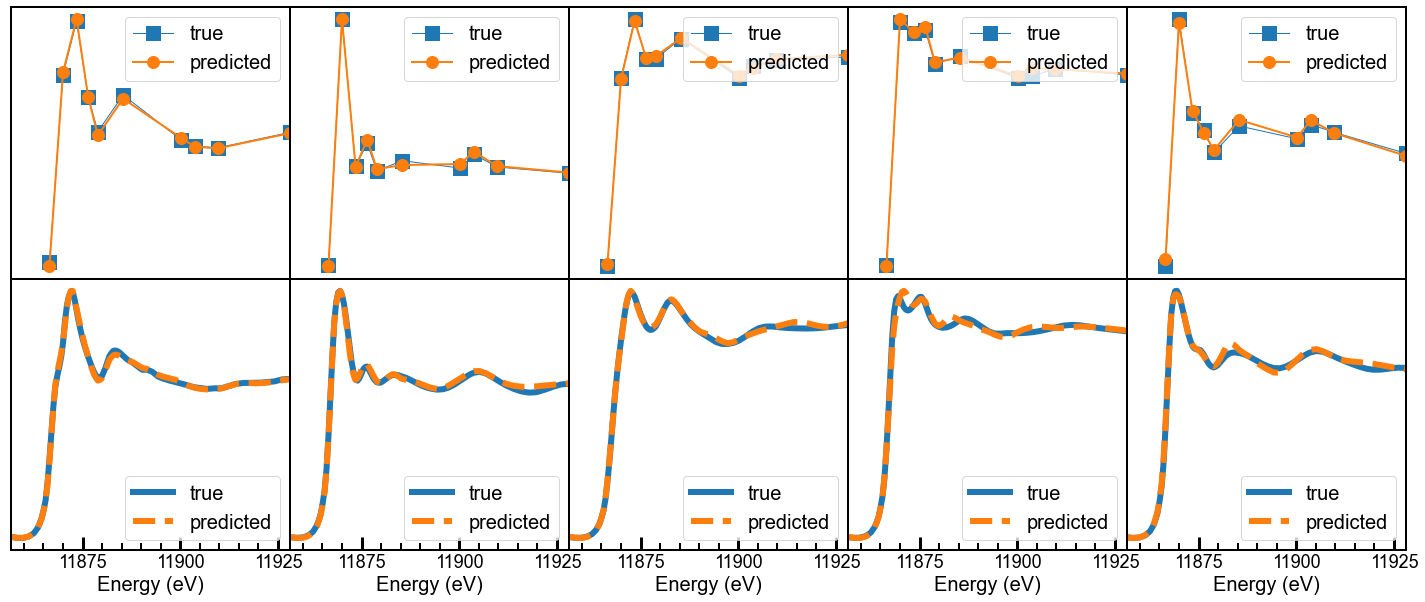

In [28]:
m = 5
fig, axes = plt.subplots(figsize=(5*m, 5*2), ncols=m, nrows=2)
plt.subplots_adjust(wspace=0, hspace=0)
n = np.argmin((Energy - 11910)**2)

for j, show_subset in enumerate([True, False]):
    for i in range(m):
        pred = Refs.T @ y_pred[i]
        true = Refs.T @ test_coeffs[i]
        ax = axes[j][i]

        if show_subset:
            ax.plot(Energy[sorted_indices], true[sorted_indices], 's-', linewidth=1, c=plt.cm.tab20(0),
                    markersize=12, markeredgewidth=3, label='true')
            ax.plot(Energy[sorted_indices], pred[sorted_indices], 'o-', linewidth=2, c=plt.cm.tab20(2),
                    markersize=12, label='predicted')
            loc = 1
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.plot(Energy, true, '-', linewidth=6, c=plt.cm.tab20(0), label='true')
            ax.plot(Energy, pred, '--', linewidth=6, c=plt.cm.tab20(2), label='predicted')
            loc = 4
            format_axis(ax, ticks=(5, 25), fontsize=20)
        
        ax.legend(fontsize=20, loc=loc)
            
        set_spine_width(ax, width=2)
        ax.set_xlim(min(Energy), max(Energy))
plt.savefig(f'Figures/test_reconstruction.png', dpi=800, transparent=True)

# Compare to Random Energies

In [97]:
noise = 0.05
kwargs = {'N': 1000, 'scale': noise, 'dropout': 0.9, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 50, 'scale': noise, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)
select = energy_point_selector.Selector(data, coeffs)

In [98]:
baseline = []
metric = 'explained_variance_score'
for i, d in enumerate(data):
    c = coeffs[i]
    p = Refs.T @ c
    p = p - np.min(p)
    score = eval(metric)(d, p)
    baseline.append(score)
baseline = np.array(baseline)
mu = np.average(baseline)
sig2 = np.std(baseline)
print(f'{mu} +/- {sig2}')

0.9824379109654141 +/- 0.0044945023734593095


In [89]:
metrics = []
ns = np.arange(4, 27, 2)
for best_n in ns:
    for mode in ['RFE', 'random']:
        if mode == 'RFE':
            rfe, cvscore = select.select_energy_points(estimator='randomforest', n_points=best_n,
                                                       scoring='neg_root_mean_squared_error', verbose=False)
            energy_measurements = Energy[rfe.support_]
            indices = [i for i, e in enumerate(Energy) if e in energy_measurements]
        else:
            indices = np.random.randint(0, high=len(Energy), size=(best_n,))
        
        reg = RandomForestRegressor()
        reg.fit(data[:, indices], coeffs)
        
        pred_coeff = reg.predict(test_data[:, indices])
        
        cv_scores = []
        m = 10
        for i in range(m):
            pred_spectra = Refs.T @ pred_coeff[i]
            pred_spectra = pred_spectra - np.min(pred_spectra)
            true_spectra = test_data[i]
        
            temp_score = eval(metric)(pred_spectra, true_spectra)
            cv_scores.append(temp_score)
        score = np.average(cv_scores)  
#         print(f'{mode}: n = {best_n}: score = {score}')
        metrics.append(score)
metrics = np.array(metrics).reshape(-1, 2)

In [ ]:
x = np.array(ns, dtype=int)
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(x, metrics[:, 0], 'o-', linewidth=2, label='RFE')
plt.plot(x, metrics[:, 1], 'o-', linewidth=2, label='Random')

ax.axhline(y=mu, c='k', linestyle='--', linewidth=2.)
xlim = ax.get_xlim()
fill = np.linspace(xlim[0], xlim[1], 2)
plt.fill_between(fill, mu - 3*sig2, y2=mu + 3*sig2, fc='gray', alpha=0.5)
plt.xlim(xlim)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_yticklabels(np.array(ax.get_yticks(), dtype=float), fontsize=16)
ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int), fontsize=16)
ax.set_xlabel('n', fontsize=18)
metric = metric.replace('_', ' ')
ax.set_ylabel(f'{metric}', fontsize=18)
ax.tick_params(direction='in', width=2, length=8, which='major')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.legend(fontsize=18)
plt.show()

# Results

In [97]:
I_choices = [[], [], []]
I_noises = [0.01, 0.03, 0.05]
I_choices[0] = [14, 24, 46, 21,  9, 18, 30, 33, 44, 50]
I_choices[1] = [15, 13, 22,  9, 24, 31, 41, 18, 20, 27]
I_choices[2] = [14, 10, 15, 13, 24, 30, 20, 18, 21, 40]

In [8]:
def get_mu_sig_of_recon(data, coeffs, Refs, metric='explained_variance_score'):
    baseline = []
    for i, d in enumerate(data):
        c = coeffs[i]
        p = Refs.T @ c
        p = p - np.min(p)
        score = eval(metric)(d, p)
        baseline.append(score)
    baseline = np.array(baseline)
    mu = np.average(baseline)
    sig = np.std(baseline)
    return mu, sig

In [132]:
def plot_recon_variance(plot, metrics, mu, sig, label=None, ylim=None,
                        metric='explained_variance_score'):
    fig, ax = plot
    x = np.arange(len(metrics))
    
    ax.plot(x, metrics, 'o-', linewidth=2, label=label)

    xlim = ax.get_xlim()
    fill = np.linspace(xlim[0], xlim[1], 2)
    ax.fill_between(fill, mu - sig, y2=mu + sig, fc='gray', alpha=0.4)
    ax.axhline(y=mu, c='k', linestyle='--', linewidth=2., alpha=0.5)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_yticklabels(np.array(ax.get_yticks(), dtype=float), fontsize=16)
    ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int) + 1, fontsize=16)
    ax.set_xlabel('n', fontsize=18)
    metric = metric.replace('_', ' ')
    label = label.replace('_', ' ')
    ax.set_ylabel(f'{metric}', fontsize=18)
    ax.tick_params(direction='in', width=2, length=8, which='major')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

In [133]:
data_noises = [0.01, 0.03, 0.05]
Metrics = [list() for i in data_noises]
Mus = [list() for i in data_noises]
Sigs = [list() for i in data_noises]
n = len(I_choices)
m = len(data_noises)

for i, indices in enumerate(I_choices):
    i_noise = I_noises[i]
    for j, data_noise in enumerate(data_noises):
        print(i, j, end='\r')
        # get data
        kwargs = {'N': 500, 'scale': data_noise, 'dropout': 0.9, 'training': False}
        train_data, train_coeffs = generate_linear_combos(Refs, **kwargs)
        kwargs = {'N': 50, 'scale': data_noise, 'dropout': 0.9, 'training': False}
        test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)
        # get results
        metrics = get_metrics(indices, train_data, train_coeffs, test_data, test_coeffs, 
                              Refs, verbose=False)
        mu, sig = get_mu_sig_of_recon(train_data, train_coeffs, Refs)
        Metrics[j].append(metrics)
        Mus[i].append(mu)
        Sigs[i].append(sig)

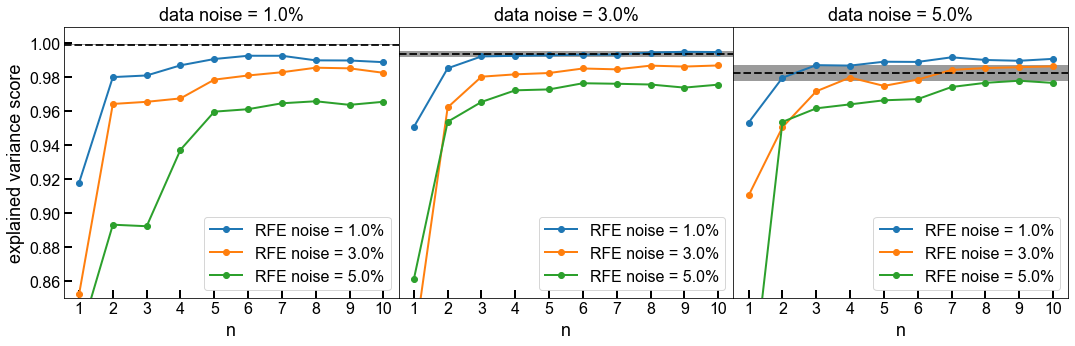

In [135]:
fig, axes = plt.subplots(figsize=(n*6, 5), nrows=1, ncols=m)
plt.subplots_adjust(wspace=0.)

for i, indices in enumerate(I_choices):
    i_noise = I_noises[i]
    for j, data_noise in enumerate(data_noises):      
        ax = axes[j]
        metrics = Metrics[i][j]
        mu = np.average([Mus[k][j] for k in range(len(Mus))])
        sig = np.average([Sigs[k][j] for k in range(len(Sigs))])
        label = f'RFE noise = {i_noise*100:.1f}%'
        plot_recon_variance((fig, ax), metrics, mu, sig, label=label, ylim=(0.85, 1.01))
        if j != 0:
            ax.set_yticks([])
            ax.set_ylabel(None)
        ax.set_title(f'data noise = {data_noise*100:.1f}%', fontsize=18)
plt.savefig(f'Figures/variance_score_noise_comparison.png', dpi=800, transparent=True)

# Data I/O

In [38]:
indices = [27, 40, 144, 20, 95, 88, 34, 45, 58, 107]
resolution = c
print(f"resolution: {resolution}")
energy_measurements = np.array(Energy[indices])
whiteline = Energy[np.argmax(Refs[24])]  # As2O3 Ref
print(f"whiteline: {whiteline} eV")
delta_Es = np.around(energy_measurements - whiteline, decimals=2)

resolution: 0.4958888888886577
whiteline: 11871.988555555556 eV


In [30]:
print(delta_Es)

[-1.98  4.46 56.04 -5.45 31.74 28.27  1.49  6.94 13.39 37.69]


In [31]:
clipped_delta_Es = delta_Es[delta_Es < 45]
clipped_energy_measurements = np.around(energy_measurements[delta_Es < 45], decimals=2)
clipped_delta_Es

array([-1.98,  4.46, -5.45, 31.74, 28.27,  1.49,  6.94, 13.39, 37.69])

In [32]:
data = np.array([clipped_energy_measurements, clipped_delta_Es]).T
df = pd.DataFrame(data, columns=['Energy measurement', 'Delta E'])
df.index = df.index + 1
df

,Energy measurement,Delta E
1,11870.00,-1.98
2,11876.45,4.46
3,11866.53,-5.45
4,11903.73,31.74
5,11900.25,28.27
6,11873.48,1.49
7,11878.93,6.94
8,11885.38,13.39
9,11909.68,37.69


In [33]:
filename = 'energy_measurements_interpolated.csv'
comments = f"Expected whiteline energy for AS2O3: {whiteline}\n"
with open(filename, 'w') as f:
    f.writelines(comments)
    df.to_csv(f, columns=df.columns)